In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import pandas as pd

In [7]:
class SoftmaxRegression(d2l.Classifier):  #@save
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))

    def forward(self, X):
        return self.net(X)

1. Deep learning uses many different number formats, including FP64 double precision (used extremely rarely),
FP32 single precision, BFLOAT16 (good for compressed representations), FP16 (very unstable), TF32 (a new format from NVIDIA), and INT8. Compute the smallest and largest argument of the exponential function for which the result does not lead to numerical underflow or overflow.

In [5]:
def get_type_info(t):
    min1, max1 = 0, 0
    if t == torch.int8:
        min1, max1 = 1, torch.iinfo(t).max
    else:
        min1, max1 = torch.finfo(t).tiny, torch.finfo(t).max
    if t not in [torch.int8, torch.float16]:
        exp_max = torch.log(torch.tensor(max1, dtype=t))
        exp_min = torch.log(torch.tensor(min1, dtype=t))
    else:
        exp_max = torch.log(torch.tensor(max1))
        exp_min = torch.log(torch.tensor(min1))
    return exp_min.item(), exp_max.item()

formats = [torch.float64, torch.float32, torch.bfloat16, torch.float16, torch.int8]
df = pd.DataFrame({'format':formats})
df[['exp_min', 'exp_max']] = df.apply(lambda x:get_type_info(x[0]),result_type="expand",axis=1)
df

,format,exp_min,exp_max
0,torch.float64,-708.396419,709.782713
1,torch.float32,-87.336548,88.722839
2,torch.bfloat16,-87.500000,88.500000
3,torch.float16,-9.704061,11.089867
4,torch.int8,0.000000,4.844187


2. INT8 is a very limited format consisting of nonzero numbers from $1$ to $255$. How could you extend its dynamic range without using more bits? Do standard multiplication and addition still work?

I can not figure out any way.

3. Increase the number of epochs for training. Why might the validation accuracy decrease after a while? How could we fix this?

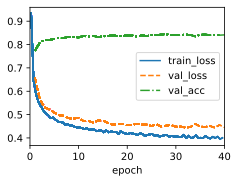

In [9]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=40)
trainer.fit(model, data)

The main reason may be that the model is overfitting. We can use regularization, early stopping, etc. to prevent the model from overfitting.

4. What happens as you increase the learning rate? Compare the loss curves for several learning rates. Which one works better? When?

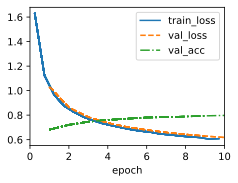

In [12]:
data = d2l.FashionMNIST(batch_size=256)

model = SoftmaxRegression(num_outputs=10, lr=0.01)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

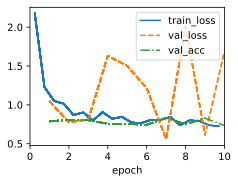

In [13]:
data = d2l.FashionMNIST(batch_size=256)

model = SoftmaxRegression(num_outputs=10, lr=0.5)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

As we increase the learning rate, the model’s weights are updated more significantly after each iteration, causing faster convergence but potentially leading to overshooting the optimal weights and divergence. 

Small Learning Rate: A small learning rate results in slow convergence and might get stuck in local minima. The loss curve may show a gradual decrease, but the convergence process can be slow.

Optimal Learning Rate: An optimal learning rate allows the model to converge smoothly and reach a low loss. The loss curve may show a steady decline with no signs of overshooting or divergence.

Large Learning Rate: A large learning rate can cause the loss curve to show oscillations, erratic behavior, and even divergence. The loss may increase instead of decreasing, indicating that the weights are bouncing around without converging.